# Introduction

The code below uses LangChain, OpenAI, neo4j, and yworks to visualize the entities and relationships from the first chapter of Frank Herbert's 1965 novel Dune.

# Setup 

Below are the modules needed.

In [43]:
import pickle
import os

import nltk
import numpy as np
import pandas as pd
import urllib3
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
import neo4j
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from nltk.tokenize import word_tokenize

load_dotenv()
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Retrieve text for Dune.

Below a text version of the nove is retrieved. 

In [2]:
target_url = 'https://raw.githubusercontent.com/ganesh-k13/shell/master/test_search/www.glozman.com/TextPages/Frank%20Herbert%20-%20Dune.txt'
http = urllib3.PoolManager()
resp = http.request("GET", target_url)
data = resp.data
bs = BeautifulSoup(data)
text = bs.prettify()
with open('dune.txt', 'w', encoding="utf-8") as f:
    f.write(text)

## Load and Clean text of Dune

The text is loaded and cleaned.

In [2]:
with open('dune.txt', 'r', encoding="utf-8") as f:
    text = f.read()

For this file, "= = = = = =" separates the chapters.

In [3]:
text_split = text.split('= = = = = =')
len(text_split)

56

Exclude appendicies and chapters smaller than 10 words.

In [4]:
import re

cleaned_text = []
for idx, line in enumerate(text_split):
    if not re.search("Appendix .+:", line) and \
       not re.search('Terminology of the Imperium', line) and \
       len( word_tokenize(line.strip()) ) > 10:
       trimmed_line = line.strip()
       #print(f'{idx }: {trimmed_line[:40].strip()}') 
       cleaned_text.append( trimmed_line )

Get some metrics from the text.

# Chapters: 48
Max # words in a chapter: 12,041
Min # words: 1,250
Average # of words: 4,961.85
Total # of words: 238,169


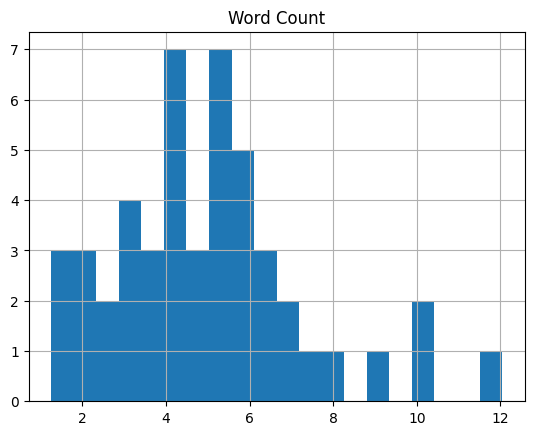

In [5]:
chpt_word_cnts = np.array([len(word_tokenize(line)) for line in cleaned_text])
print(f'# Chapters: {len(chpt_word_cnts)}')
print(f'Max # words in a chapter: {chpt_word_cnts.max():,}')
print(f'Min # words: {chpt_word_cnts.min():,}')
print(f'Average # of words: {chpt_word_cnts.mean():,.2f}')
print(f'Total # of words: {chpt_word_cnts.sum():,}')

cnt_df = pd.DataFrame(data={'Word Count': chpt_word_cnts/1000})
hist = cnt_df.hist(bins=20)

This text file contains spaces before each paragraph. The code below removes those spaces. 

In [6]:
for idx, chapter in enumerate(cleaned_text):
    chapter_text = []
    for line in chapter.split('\r\n'):
        line = line.strip()
        if len(line) > 0:
            chapter_text.append(line)
    cleaned_text[idx] = '\r\n'.join(chapter_text)

Collect text metrics again to confirm stripping out spaces didn't impact the text.

# Chapters: 48
Max # words in a chapter: 12,041
Min # words: 1,250
Average # of words: 4,961.85
Total # of words: 238,169


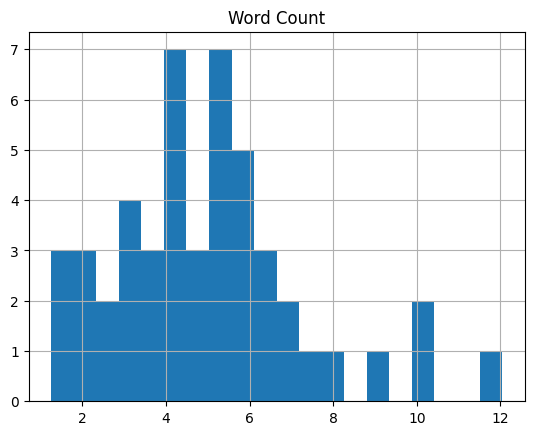

In [7]:
chpt_word_cnts = np.array([len(word_tokenize(line)) for line in cleaned_text])
print(f'# Chapters: {len(chpt_word_cnts)}')
print(f'Max # words in a chapter: {chpt_word_cnts.max():,}')
print(f'Min # words: {chpt_word_cnts.min():,}')
print(f'Average # of words: {chpt_word_cnts.mean():,.2f}')
print(f'Total # of words: {chpt_word_cnts.sum():,}')

cnt_df = pd.DataFrame(data={'Word Count': chpt_word_cnts/1000})
hist = cnt_df.hist(bins=20)

# Summarize entities and relationships for each chapter.

Chapter summaries of two OpenAI models are compared below.

## Prompt

The prompt is created.

In [9]:
# Define the map prompt template
summary_template = """Using the context below, please find entities and relationships for people, organizations, planets, or groups.:
------------
{context}
------------
Based on the context above, please find entities and relationships for people, organizations, planets, or groups.
Only include frequently mentioned entities.
Provide entity type.
Separate the entities and relationships. 
Below are examples of entities:
------------
1. Barry Allan (Person)
2. Olive Oil (Person)
3. Earth (Planet)
4. Popeye The Sailor (Person)
5. Castle Grayskull (Place)
------------
Below are examples of relationships:
------------
1. Barry Allan lives on Earth.
2. Olive Oil is Popeye The Sailor's girlfriend.
3. Barry Allan is a superhero.
5. Barry Allan lives in Castle Grayskull.
------------
IMPORTANT NOTES:
- Don't add extra explanation.
- Remove duplicates.
Helpful Answer:"""
summary_prompt = PromptTemplate.from_template(summary_template)

## GPT Trubo Chapter Summary

The first chapter of the novel is summarized using GPT 3.5 Turbo.

In [10]:
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106")
summary_chain = summary_prompt | llm | StrOutputParser()
gptTurbo_result = summary_chain.invoke(cleaned_text[0])

In [12]:
print( gptTurbo_result )

Entities:
1. Muad'Dib (Person)
2. Princess Irulan (Person)
3. Arrakis (Planet)
4. Bene Gesserit (Organization)
5. House of Atreides (Group)
6. Harkonnens (Group)
7. Duke Leto (Person)
8. Reverend Mother Gaius Helen Mohiam (Person)
9. Paul (Person)
10. Jessica (Person)

Relationships:
1. Muad'Dib was born in the 57th year of the Padishah Emperor, Shaddam IV.
2. Muad'Dib was born on Caladan and lived his first fifteen years there.
3. Muad'Dib is located on the planet Arrakis.
4. Arrakis is known as Dune.
5. The Harkonnens have been on Arrakis for eighty years.
6. The Harkonnens are leaving Arrakis to be replaced by the House of Atreides.
7. Duke Leto is the father of Paul.
8. Reverend Mother Gaius Helen Mohiam is a member of the Bene Gesserit.
9. Jessica is a Bene Gesserit Lady and the mother of Paul.
10. Paul undergoes a test administered by the Reverend Mother Gaius Helen Mohiam.


## GPT-4o Chapter Summary

The same chapter is summarized using GPT-4o

In [14]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
summary_chain = summary_prompt | llm | StrOutputParser()
gpt4o_result = summary_chain.invoke(cleaned_text[0])
print( gpt4o_result )

Entities:
------------
1. Paul (Person)
2. Jessica (Person)
3. Reverend Mother Gaius Helen Mohiam (Person)
4. Thufir Hawat (Person)
5. Duke Leto (Person)
6. Shaddam IV (Person)
7. Princess Irulan (Person)
8. Dr. Yueh (Person)
9. Harkonnens (Group)
10. Bene Gesserit (Organization)
11. House of Atreides (Group)
12. Spacing Guild (Organization)
13. Landsraad (Organization)
14. Padishah Emperor (Title)
15. Caladan (Planet)
16. Arrakis (Planet)
17. Castle Caladan (Place)
18. CHOAM Company (Organization)
19. Fremen (Group)
20. Kwisatz Haderach (Title)
21. Padishah Emperor's Truthsayer (Title)

Relationships:
------------
1. Paul is Jessica's son.
2. Paul lives on Caladan.
3. Paul is a member of House of Atreides.
4. Jessica is a Bene Gesserit Lady.
5. Jessica is Duke Leto's concubine.
6. Reverend Mother Gaius Helen Mohiam is a Bene Gesserit.
7. Reverend Mother Gaius Helen Mohiam is the Padishah Emperor's Truthsayer.
8. Thufir Hawat is Duke Leto's Master of Assassins.
9. Duke Leto is the head

## Results

GPT-4o appears to provide a better summary. At least for my prompt. GPT-4o will be used in the steps that follow.

# Create Entity and Relationship Cypher statements

Using the context generated above, the code below creates Cypher statements for the entities and relationships.

In [21]:
docs = [Document(page_content=gpt4o_result)]

graph_text = """
You are a Neo4j expert that writes Cypher entity and relationship statements from context.
Below is the context:
------------
{context}
------------
Create nodes only for the entity types below:
------------
Person
Group
Organization
Planet
------------
Create relationships for the types below:
------------
CHILD_OF
PARENT_OF
MEMBER_OF
LOCATED_ON
MARRIED_TO
ASSOCIATE_OF
ENEMY_OF
SIBLING_OF
------------
Use the context to write Cypher entity and relationship statements.
Include no other comments.
Helpful Answer:
"""
graph_prompt = PromptTemplate.from_template(graph_text)

In [22]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o") 
gpt4o_graph_chain = graph_prompt | llm | StrOutputParser()
gpt4o_graph_result = gpt4o_graph_chain.invoke({'context': docs})
print( gpt4o_graph_result )

```cypher
CREATE (paul:Person {name: 'Paul'})
CREATE (jessica:Person {name: 'Jessica'})
CREATE (reverendMotherGaiusHelenMohiam:Person {name: 'Reverend Mother Gaius Helen Mohiam'})
CREATE (thufirHawat:Person {name: 'Thufir Hawat'})
CREATE (dukeLeto:Person {name: 'Duke Leto'})
CREATE (shaddamIV:Person {name: 'Shaddam IV'})
CREATE (princessIrulan:Person {name: 'Princess Irulan'})
CREATE (drYueh:Person {name: 'Dr. Yueh'})
CREATE (harkonnens:Group {name: 'Harkonnens'})
CREATE (houseOfAtreides:Group {name: 'House of Atreides'})
CREATE (beneGesserit:Organization {name: 'Bene Gesserit'})
CREATE (spacingGuild:Organization {name: 'Spacing Guild'})
CREATE (landsraad:Organization {name: 'Landsraad'})
CREATE (caladan:Planet {name: 'Caladan'})
CREATE (arrakis:Planet {name: 'Arrakis'})

CREATE (paul)-[:CHILD_OF]->(jessica)
CREATE (jessica)-[:PARENT_OF]->(paul)
CREATE (paul)-[:MEMBER_OF]->(houseOfAtreides)
CREATE (paul)-[:LOCATED_ON]->(caladan)
CREATE (jessica)-[:MEMBER_OF]->(beneGesserit)
CREATE (jes

# Create the Graph Database

The code below creates a connection to a local instance of neo4j and runs the Cypher statements generated above.

In [ ]:
neo4j_url = os.getenv("NEO4J_CONNECTION_URL")
neo4j_user = os.getenv("NEO4J_USER")
neo4j_password = os.getenv("NEO4J_PASSWORD")

def run(tx, stmt):
    result = tx.run(stmt)
    return result.consume()

def execute_write(stmt):
    driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))
    with driver.session(database="neo4j") as session:
        result_summary = session.execute_write(run, stmt)
    driver.close() 

execute_write('MATCH (n) DETACH DELETE n;')

execute_write(gpt4o_graph_result.replace('```cypher','').replace('```',''))

# Visualize Graph

ywork's graping widget will be used to visualize the graph stored in neo4j.

The widget only appears after running the code below.

In [ ]:
def execute_read(stmt):
    driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))
    with driver.session(database="neo4j") as session:
        graph = session.run(stmt).graph()
    return graph

graph = execute_read('MATCH (n)-[r]->(m) RETURN  n, m, r')

def custom_node_label_mapping(node: dict):
    return node['properties']['name']

gw = GraphWidget(graph = graph)
gw.set_node_label_mapping(custom_node_label_mapping)
gw.directed = True
gw.set_graph_layout('hierarchic')
gw.set_sidebar(enabled = False, start_with = 'Neighborhood')
gw.show()

Below is screenshot of the interactive widget displayed by the code above.

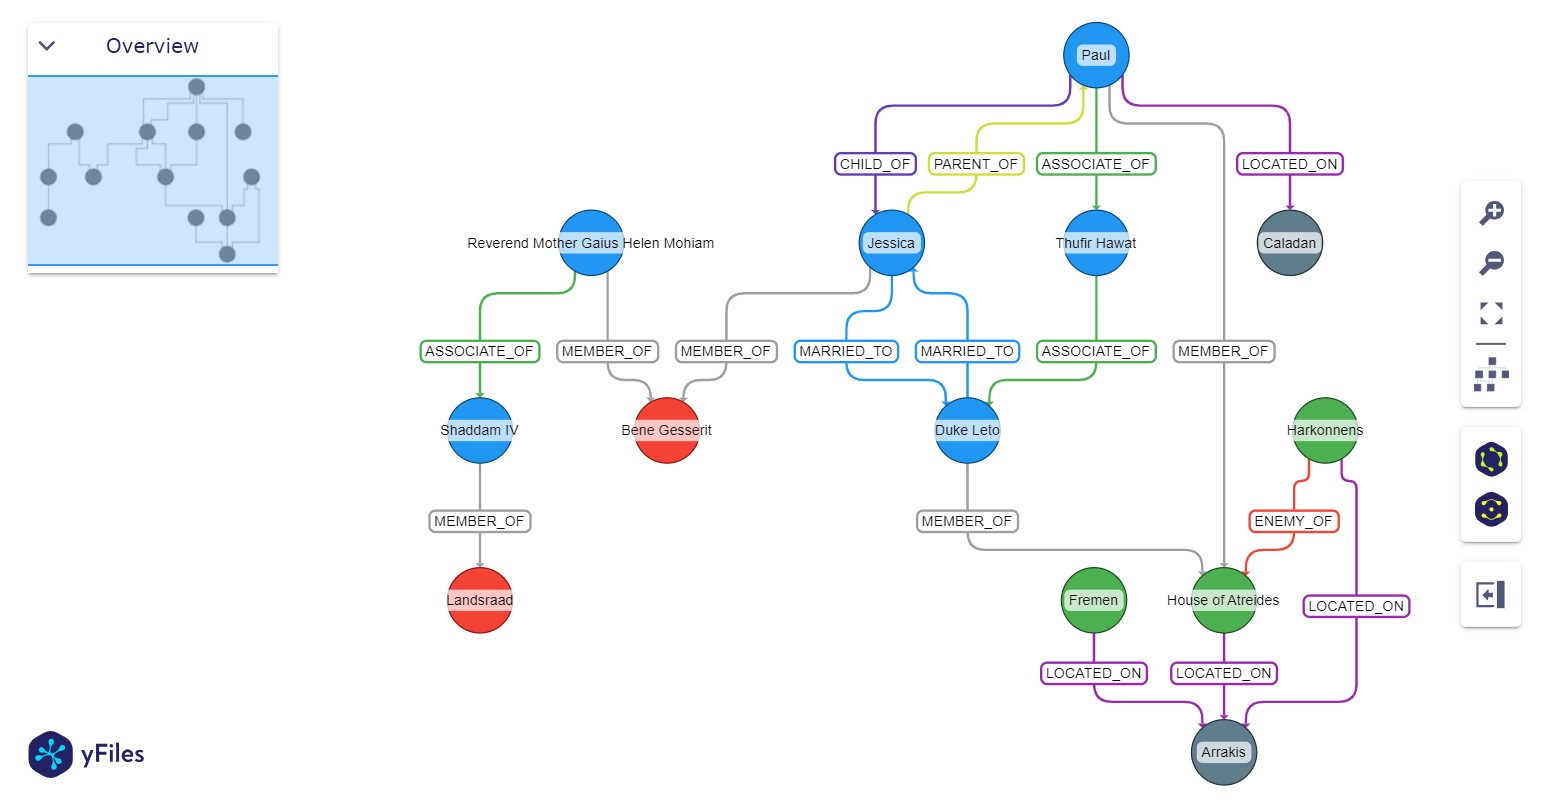

In [47]:
from IPython.display import Image
Image(filename='graph.jpg')